In [1]:
import sys
sys.path.insert(0, '/tf/utils/')

In [2]:
import numpy as np
import os
# Definir o nível de log do TensorFlow para ERROR
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Input, Concatenate, concatenate, UpSampling2D, LayerNormalization, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, Reshape, Conv2DTranspose

from utils import add_white_gaussian_noise, somar_sinais

import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.signal import stft, istft
import librosa

In [3]:
from sound import Sound

In [4]:
base_shape_size = 8192

In [5]:
sound_base = Sound('../Dados/Base/', '../Dados/ESC-50-master/audio/', base_shape_size)

Loading noise files: 100%|██████████| 2000/2000 [00:09<00:00, 211.82it/s]


In [6]:
sound = sound_base.train_X[0]

In [7]:
noisy_sound = add_white_gaussian_noise(sound, 10.0)
noisy_sound = np.clip(noisy_sound, -1, 1)

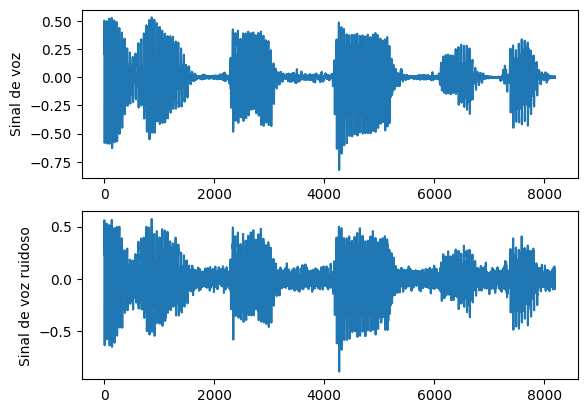

In [8]:
# Criando figuras e eixos separados para cada array
fig, (ax1, ax2) = plt.subplots(2, 1)

# Plotando o primeiro array
ax1.plot(sound)
ax1.set_ylabel('Sinal de voz')

ax2.plot(noisy_sound)
ax2.set_ylabel('Sinal de voz ruidoso')

# Exibindo os gráficos
plt.show()

In [9]:
Audio(data=sound, rate=8000)

In [10]:
Audio(data=noisy_sound, rate=8000)

In [11]:
from scipy.signal import spectrogram
from scipy.signal import istft

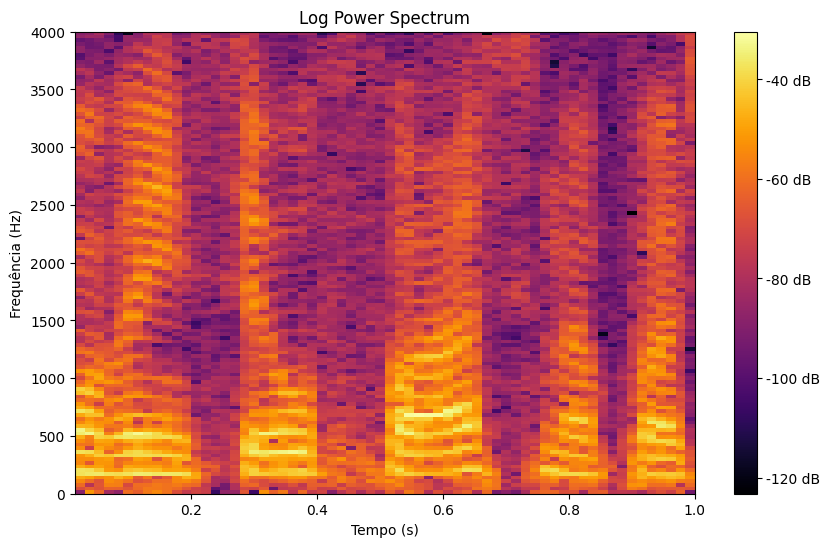

In [12]:
# Calcule o espectrograma para cada janela
f, t, Sxx = spectrogram(sound, fs=8000, nperseg=250, noverlap=125)

# Calcule o log power spectrum
log_power_spectrum = 10 * np.log10(Sxx)

# Plote o log power spectrum
plt.figure(figsize=(10, 6))
plt.imshow(log_power_spectrum, aspect='auto', cmap='inferno', origin='lower', extent=[t.min(), t.max(), f.min(), f.max()])
plt.title('Log Power Spectrum')
plt.xlabel('Tempo (s)')
plt.ylabel('Frequência (Hz)')
plt.colorbar(format='%+2.0f dB')
plt.show()

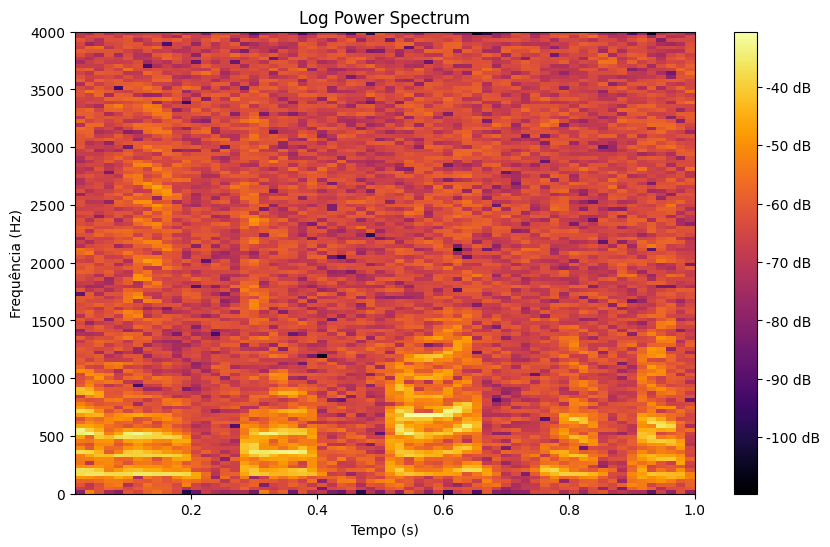

In [13]:
# Calcule o espectrograma para cada janela
f, t, Sxx = spectrogram(noisy_sound, fs=8000, nperseg=250, noverlap=125)

# Calcule o log power spectrum
log_power_spectrum = 10 * np.log10(Sxx)

# Plote o log power spectrum
plt.figure(figsize=(10, 6))
plt.imshow(log_power_spectrum, aspect='auto', cmap='inferno', origin='lower', extent=[t.min(), t.max(), f.min(), f.max()])
plt.title('Log Power Spectrum')
plt.xlabel('Tempo (s)')
plt.ylabel('Frequência (Hz)')
plt.colorbar(format='%+2.0f dB')
plt.show()

In [14]:
# Transforme o log power spectrum de volta para o domínio linear
overlap = 125
window_size = 250

power_spectrum = 10 ** (log_power_spectrum / 10)

# Calcule o número de janelas
num_windows = power_spectrum.shape[1]

# Calcule o número de pontos na FFT
nfft = 2 * (power_spectrum.shape[0] - 1)

# Inicialize um array para o sinal reconstruído
reconstructed_signal = np.zeros(num_windows * overlap + window_size - overlap)

for i in range(num_windows):
    # Calcule a inversa da transformada de Fourier de cada janela
    if i == num_windows - 1:
        window = np.fft.irfft(power_spectrum[:, i], n=nfft)
    else:
        window = np.fft.irfft(power_spectrum[:, i], n=nfft)[:window_size]

    # Sobreponha as janelas para reconstruir o sinal completo
    start = i * overlap
    end = start + window_size
    reconstructed_signal[start:end] += window

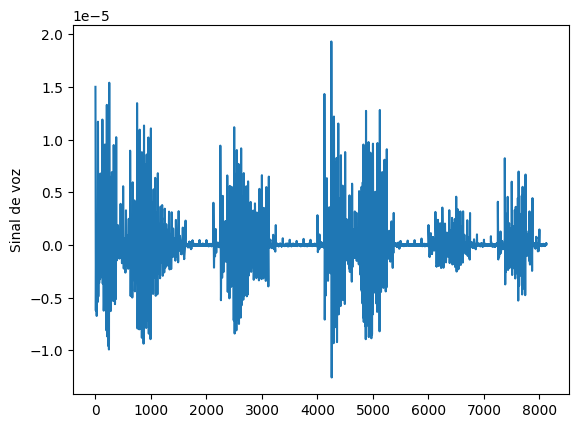

In [15]:
# Criando figuras e eixos separados para cada array
fig, (ax1) = plt.subplots(1, 1)

# Plotando o primeiro array
ax1.plot(reconstructed_signal)
ax1.set_ylabel('Sinal de voz')

# Exibindo os gráficos
plt.show()

In [16]:
Audio(data=reconstructed_signal, rate=8000)

In [17]:
ws = 255
ol = 128

In [18]:
# def calculate_stft_magnitude_and_phase(signal, sampling_rate=8000, window_size=ws, overlap=ol):
#     f, t, Zxx = stft(signal, fs=sampling_rate, nperseg=window_size, noverlap=overlap)
    
#     magnitude = np.abs(Zxx)
#     phase = np.angle(Zxx)

#     return magnitude, phase, f, t

# def reconstruct_signal_from_stft(magnitude, phase, sampling_rate=8000, window_size=ws, overlap=ol):
#     # Reconstruct the signal from magnitude and phase
#     Zxx = magnitude * np.exp(1j * phase)
#     _, signal = istft(Zxx, fs=sampling_rate, nperseg=window_size, noverlap=overlap)
    
#     return signal

In [19]:
def calculate_stft_magnitude_and_phase(signal, sampling_rate=8000, window_size=ws, overlap=ol):
    # Calcula a STFT usando a biblioteca librosa
    stft_result = librosa.stft(signal, n_fft=window_size, hop_length=overlap)
    
    magnitude, phase = librosa.magphase(stft_result)
    phi = np.angle(phase)
    f = librosa.fft_frequencies(sr=sampling_rate, n_fft=window_size)
    t = librosa.frames_to_time(np.arange(stft_result.shape[1]), sr=sampling_rate, hop_length=overlap)

    return magnitude, phi, f, t

def reconstruct_signal_from_stft(magnitude, phi, sampling_rate=8000, window_size=ws, overlap=ol):
    # Reconstruct the signal from magnitude and phase
    complex_spec = magnitude * np.exp(1j * phi)
    signal = librosa.istft(complex_spec, hop_length=overlap)

    return signal

In [20]:
a = noisy_sound

In [21]:
A, phi, f, t = calculate_stft_magnitude_and_phase(a)

In [22]:
A.shape

(128, 64)

In [23]:
print(np.max(A))
print(np.max(phi))
print(np.min(A))
print(np.min(phi))

15.339748
3.1415927
0.005019471
-3.141015


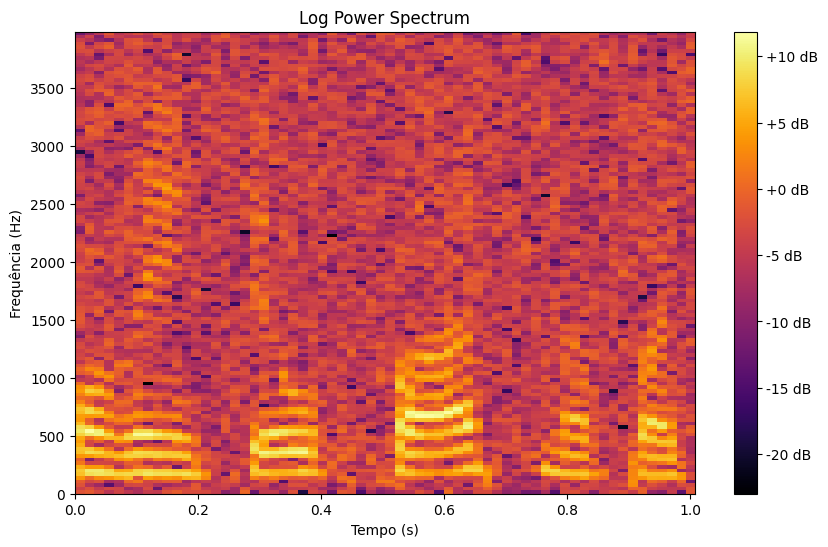

In [24]:
plt.figure(figsize=(10, 6))
plt.imshow(10*np.log10(A), aspect='auto', cmap='inferno', origin='lower', extent=[t.min(), t.max(), f.min(), f.max()])
plt.title('Log Power Spectrum')
plt.xlabel('Tempo (s)')
plt.ylabel('Frequência (Hz)')
plt.colorbar(format='%+2.0f dB')
plt.show()

In [25]:
s = reconstruct_signal_from_stft(A, phi)

In [26]:
Audio(data=s, rate=8000)

In [27]:
F = np.concatenate([A.reshape(A.shape[0], A.shape[1], 1), phi.reshape(phi.shape[0], phi.shape[1], 1)], axis=-1)

In [28]:
F.shape

(128, 64, 2)

In [29]:
phi.shape

(128, 64)

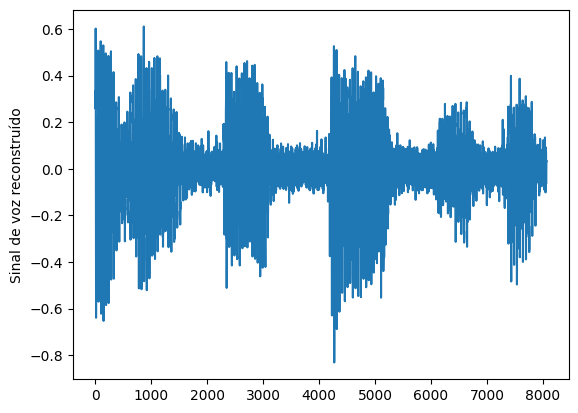

In [30]:
# Criando figuras e eixos separados para cada array
fig, (ax1) = plt.subplots(1, 1)

# Plotando o primeiro array
ax1.plot(s)
ax1.set_ylabel('Sinal de voz reconstruído')

# Exibindo os gráficos
plt.show()

In [31]:
Audio(data=s, rate=8000)

In [54]:
class DataGenerator:
    def __init__(self, sound_files, noise_files):
        self.sound_files = sound_files
        self.noise_files = noise_files

    def generate_sample_completo(self, batch_size=32):
        while True:
            # Carrega um lote de sons
            sound_batch_choices = np.random.choice(self.sound_files.shape[0], size=batch_size, replace=False)
            sound_batch = self.sound_files[sound_batch_choices]
            
            # Carrega um lote de ruídos
            noise_batch_choices = np.random.choice(self.noise_files.shape[0], size=batch_size, replace=False)
            noise_batch = self.noise_files[noise_batch_choices]
            
            x_train = []
            y_train = []

            xA_batch = []
            xphi_batch = []
            yA_batch = []
            yphi_batch = []
            
            # Adiciona ruído a cada som e calcula a nota PESQ
            for sound, noise in zip(sound_batch, noise_batch):
                # sr = np.random.randint(-5, 60, size=(1,)[0])
                # noisy_sound = somar_sinais(sound, noise, sr)
                
                # noisy_sound = add_white_gaussian_noise(noisy_sound, np.random.randint(20, 30, size=(1,)[0]))
                noisy_sound = add_white_gaussian_noise(sound, np.random.randint(20, 30, size=(1,)[0]))
                noisy_sound = np.clip(noisy_sound, -1.0, 1.0)
                
                A, phi, _, _ = calculate_stft_magnitude_and_phase(sound)
                A_noisy, phi_noisy, _, _ = calculate_stft_magnitude_and_phase(noisy_sound)

                A /= ws
                A_noisy /= ws

                # xA_batch.append(A)
                # xphi_batch.append(phi)
                # yA_batch.append(A_noisy)
                # yphi_batch.append(phi_noisy)
                
                # Monta o fasor normalizando a faze por Pi
                F = np.concatenate([A.reshape(A.shape[0], A.shape[1], 1), (phi.reshape(phi.shape[0], phi.shape[1], 1) / (2*np.pi)) + 0.5], axis=-1)
                F_noisy = np.concatenate([A_noisy.reshape(A_noisy.shape[0], A_noisy.shape[1], 1), (phi_noisy.reshape(phi_noisy.shape[0], phi_noisy.shape[1], 1) / (2*np.pi)) + 0.5], axis=-1)
                
                # Adiciona o exemplo ao lote de treinamento
                x_train.append(F_noisy)
                y_train.append(F)

            x_train = np.array(x_train)
            y_train = np.array(y_train)
            
            yield x_train, y_train

In [55]:
data_generator_train = DataGenerator(sound_base.train_X, sound_base.noise_sounds)
data_generator_val = DataGenerator(sound_base.val_X, sound_base.noise_sounds)

In [56]:
validation_batch = next(data_generator_train.generate_sample_completo(batch_size=32))
x_val, y_val = validation_batch

In [57]:
x_val.shape

(32, 128, 64, 2)

In [120]:
def unet(inputs):
    # Codificador
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # Camada central
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    
    # Decodificador
    up4 = UpSampling2D(size=(2, 2))(conv3)
    up4 = Conv2D(128, 2, activation='relu', padding='same')(up4)
    merge4 = concatenate([conv2, up4], axis=3)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(merge4)
    
    up5 = UpSampling2D(size=(2, 2))(conv4)
    up5 = Conv2D(64, 2, activation='relu', padding='same')(up5)
    merge5 = concatenate([conv1, up5], axis=3)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(merge5)
    
    # Camada de saída
    output = Conv2D(2, 3, activation='relu', padding='same')(conv5)
    flat = Flatten()(output)
    den = Dense(128*64*2, 'sigmoid')(flat)
    # den = Dense(128*64*2, 'sigmoid')(den)
    outputs = Reshape((128, 64, 2))(den)

    return outputs

In [121]:
inputs = Input((x_val.shape[1], x_val.shape[2],x_val.shape[3]))
outputs = unet(inputs)
model = Model(inputs=inputs, outputs=outputs)

ResourceExhaustedError: {{function_node __wrapped__AddV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:AddV2]

In [ ]:
model.summary()

In [116]:
model.compile(optimizer='adam', loss='mse')

In [117]:
batch_size = 64
steps_per_epoch = len(sound_base.train_X) // batch_size

print('Starting training')

for epoch in range(5):
    print(f"Epoch {epoch + 1}")
    
    # Gera um novo lote de validação para cada época
    validation_batch = next(data_generator_val.generate_sample_completo(batch_size=batch_size))
    x_val, y_val = validation_batch
    
    model.fit(data_generator_train.generate_sample_completo(batch_size=batch_size),
                     steps_per_epoch=steps_per_epoch,
                     epochs=1,
                     validation_data=(x_val, y_val),
                    )

Starting training
Epoch 1


ResourceExhaustedError: in user code:

    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1054, in train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer.py", line 543, in minimize
        self.apply_gradients(grads_and_vars)
    File "/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer.py", line 1174, in apply_gradients
        return super().apply_gradients(grads_and_vars, name=name)
    File "/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer.py", line 637, in apply_gradients
        self.build(trainable_variables)
    File "/usr/local/lib/python3.8/dist-packages/keras/optimizers/adam.py", line 139, in build
        self.add_variable_from_reference(
    File "/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer.py", line 1106, in add_variable_from_reference
        return super().add_variable_from_reference(
    File "/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer.py", line 507, in add_variable_from_reference
        initial_value = tf.zeros(

    ResourceExhaustedError: {{function_node __wrapped__Fill_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[16384,16384] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Fill]


In [75]:
x_test, y_test = next(data_generator_val.generate_sample_completo(batch_size=1))

In [76]:
print(np.max(x_test[:, :, : , 0]))
print(np.min(x_test[:, :, : , 0]))
print(np.max(y_test[:, :, : , 0]))
print(np.min(y_test[:, :, : , 0]))

0.118499696
1.9962806e-06
0.11869012
3.061808e-06


In [77]:
F_f = model.predict(x_test)

1/1 [==============================] - 0s 373ms/step


In [78]:
print(np.max(F_f))
print(np.min(F_f))
print(F_f.shape)

1.0448669
0.0
(1, 128, 64, 2)


In [80]:
A = y_test.reshape(y_test.shape[1], y_test.shape[2], y_test.shape[3])[:, :, 0]
phi = (y_test.reshape(y_test.shape[1], y_test.shape[2], y_test.shape[3])[:, :, 1] - 0.5) * 2 * np.pi

A_f = F_f.reshape(F_f.shape[1], F_f.shape[2], F_f.shape[3])[:, :, 0]
phi_f = (F_f.reshape(F_f.shape[1], F_f.shape[2], F_f.shape[3])[:, :, 1] - 0.5) * 2 * np.pi

A_n = x_test.reshape(x_test.shape[1], x_test.shape[2], x_test.shape[3])[:, :, 0]
phi_n = (x_test.reshape(x_test.shape[1], x_test.shape[2], x_test.shape[3])[:, :, 1] - 0.5) * 2 * np.pi

In [91]:
print(np.max(A_f))
print(np.max(phi_f))
print(np.min(A_f))
print(np.min(phi_f))

0.0
3.4234998
0.0
-2.822004


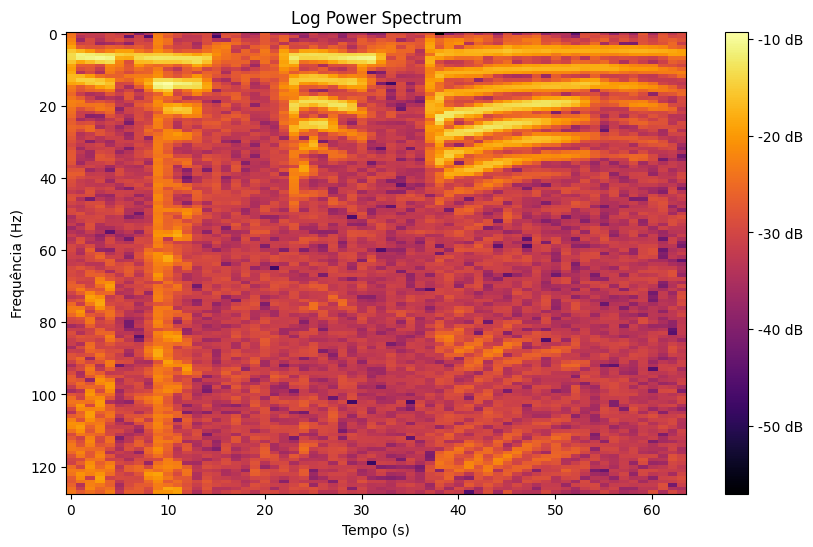

In [89]:
plt.figure(figsize=(10, 6))
plt.imshow(10*np.log10(A_n), aspect='auto', cmap='inferno')
plt.title('Log Power Spectrum')
plt.xlabel('Tempo (s)')
plt.ylabel('Frequência (Hz)')
plt.colorbar(format='%+2.0f dB')
plt.show()

In [83]:
s = reconstruct_signal_from_stft(A, phi)
s_n = reconstruct_signal_from_stft(A_n, phi_n)
s_f = reconstruct_signal_from_stft(A_f*255, phi_f)

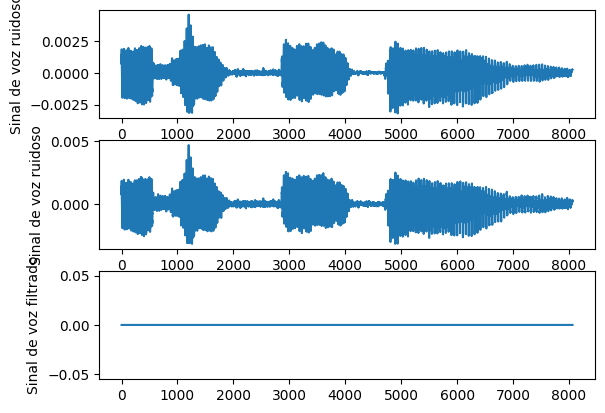

In [84]:
# Criando figuras e eixos separados para cada array
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

# Plotando o primeiro array
ax1.plot(s)
ax1.set_ylabel('Sinal de voz ruidoso')

# Plotando o primeiro array
ax2.plot(s_n)
ax2.set_ylabel('Sinal de voz ruidoso')

ax3.plot(s_f)
ax3.set_ylabel('Sinal de voz filtrado')

# Exibindo os gráficos
plt.show()

In [54]:
Audio(data=s, rate=8000)

In [55]:
Audio(data=s_n, rate=8000)

In [56]:
Audio(data=s_f, rate=8000)